In [1]:
from lanczos import *

In [2]:
L, g, J = 14, 1.5, 1.
sx_list, sz_list = gen_sx_list(L), gen_sz_list(L)
H = gen_hamiltonian(sx_list, sz_list, g, J)

psi_init = np.random.random(H.shape[0])

In [3]:
for stabilize in [False, True]:
    T, vecs = lanczos(psi_init, H, N=200, stabilize=stabilize)
    E = np.linalg.eigvalsh(T)
    print(E[:10])

[-23.40758298 -23.40758298 -23.40758298 -22.40634977 -22.40634977
 -22.40634977 -21.92703453 -21.92703453 -21.12647356 -21.12647356]
[-23.40758298 -22.40634977 -21.92703453 -21.92703453 -21.12647356
 -21.05728137 -21.05728137 -20.36491833 -20.36491833 -20.19235712]


We observe a 3-fold ground state degeneracy, when setting `stabilize=False`. However, for the given model parameters we do not expect any degeneracy. Setting `stabilize=True` yields the correct behavior.

The reason for this is that the Lanczos algorithm is numerically unstable. While the generated vectors should be orthogonal, finite precision floating points on the computer introduce rounding errors, due to which the orthogonality is lost. Hence, multiple eigenvectors of T correspond to the same vector in the original basis, explaining the artificial degeneracy. Activating the option `stabilize=True` enables an explicit orthogonalization against all previously generated vectors. In this case, the degeneracy is captured correctly.

In [4]:
psi_init = np.random.random(H.shape[0])
T, vecs = lanczos(psi_init, H, N=200, stabilize=True)

E, u = np.linalg.eigh(T)
u0 = u[:, 0]
psi0 = np.transpose(vecs) @ u0
E0 = np.inner(psi0, H@psi0)
print(E0, E[0])
print(np.inner(psi0, H@H@psi0) - E0**2)

-23.407582982021598 -23.40758298202164
1.3642420526593924e-12


In [5]:
Sp0 = singlesite_to_full(Splus, 0, L)
phi0 = Sp0 @ psi0
T, vecs = lanczos(phi0, H, N=200, stabilize=True)

In [6]:
def calc_I(T, z):
    N = T.shape[0]
    α, β = np.diag(T), np.diag(T, k=1)
    ratio = 1./(z - α[N-2] - β[N-2]**2/(z - α[N-1]))
    for n in reversed(range(N-2)):
        ratio = 1./(z - α[n] - β[n]**2 * ratio)
        
    return -1./np.pi * np.imag(ratio)

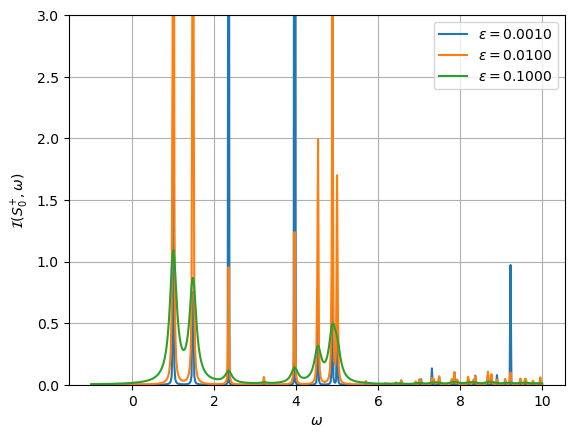

In [7]:
ωs = np.linspace(-1., 10., 500)
fig, ax = plt.subplots(1, 1)
for ε in [0.001, 0.01, 0.1]:
    z = ωs  + E0 + 1.j*ε
    I = calc_I(T, z)
    ax.plot(ωs, I, label="$\\varepsilon=%.4f}$" % (ε))
ax.set_ylim(0., 3.), ax.set_xlabel("$\\omega$"), ax.set_ylabel("$\mathcal{I}(S_{0}^{+}, \\omega)$"), ax.legend(), ax.grid();

In [14]:
def construct_Sp_k(L):
    ks = np.arange(-L/2, L/2 + 1, 1) * (2*np.pi)/L
    Sp_k_list  = []
    for k in ks:
        Sp_k = 0
        for i in range(L):
            Sp_k = Sp_k + np.exp(1.j*k*i) * singlesite_to_full(Splus, i, L)
        Sp_k /= np.sqrt(L)
        Sp_k_list.append(Sp_k)

    return Sp_k_list

In [15]:
Sp_k_list = construct_Sp_k(L)
ωs = np.linspace(-1., 8., 300)
ε = 0.03
Is = list()
for Sp_k in Sp_k_list:
    phi0 = Sp_k @ psi0
    T, vecs = lanczos(phi0, H, N=200, stabilize=True)
    z = ωs  + E0 + 1.j*ε
    I = calc_I(T, z)
    Is.append(I)
Is = np.array(Is)

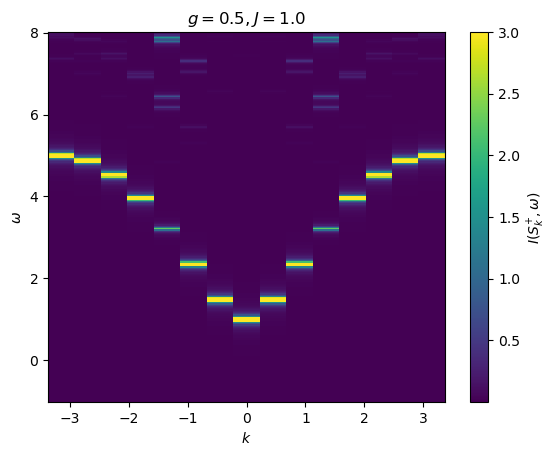

In [16]:
colorplot(ks, ωs, Is, vmax=3.)
plt.xlabel("$k$"), 
plt.ylabel("$\\omega$"), 
plt.colorbar().set_label("$I(S^{+}_{k}, \\omega)$")
plt.title("$g={g:.1f}$".format(g=g))
plt.title("$g={g:.1f}, J={J:.1f}$".format(g=g, J=J))
plt.show()

In [17]:
def gen_plot_I(g, J, L=14, N=200):

    # Find ground state and its energy
    sx_list, sz_list = gen_sx_list(L), gen_sz_list(L)
    H = gen_hamiltonian(sx_list, sz_list, g, J)
    psi_init = np.random.random(H.shape[0])
    T, vecs = lanczos(psi_init, H, N=N, stabilize=True)
    E, u = np.linalg.eigh(T)
    E0, u0 = E[0], u[:, 0]
    psi0 = np.transpose(vecs) @ u0

    # Construct momentum-dependent operators
    Sp_k_list = construct_Sp_k(L)

    # Run lanczos for different initial states to compute I(Splus_k, omega)
    ωs = np.linspace(-1., 8., 300)
    ε = 0.03
    Is = [] 
    for Sp_k in Sp_k_list:
        
        phi0 = Sp_k @ psi0
        T, _ = lanczos(phi0, H, N=N, stabilize=True)
        z = ωs  + E0 + 1.j*ε
        I = calc_I(T, z)
        Is.append(I)
        
    Is = np.array(Is)

    colorplot(ks, ωs, Is, vmax=3.)
    plt.xlabel("$k$"), 
    plt.ylabel("$\\omega$"), 
    plt.colorbar().set_label("$I(S^{+}_{k}, \\omega)$")
    plt.title("$g={g:.1f}$".format(g=g))
    plt.title("$g={g:.1f}, J={J:.1f}$".format(g=g, J=J))
    plt.show()

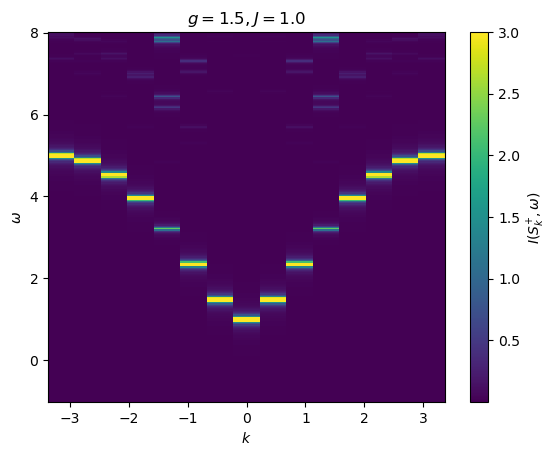

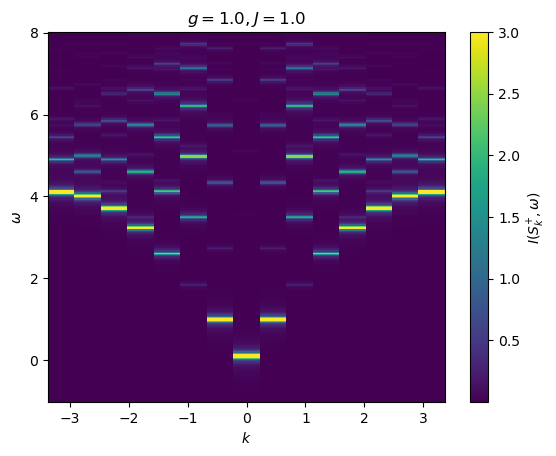

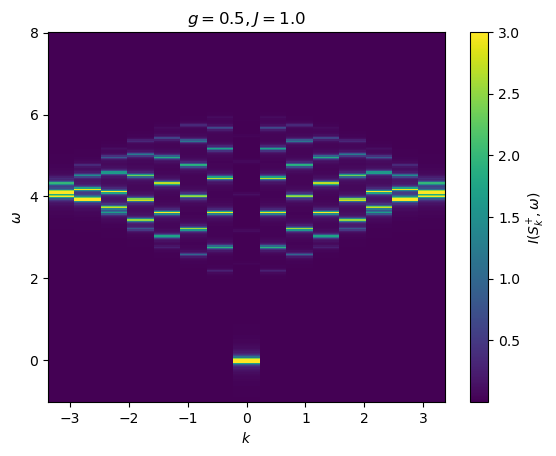

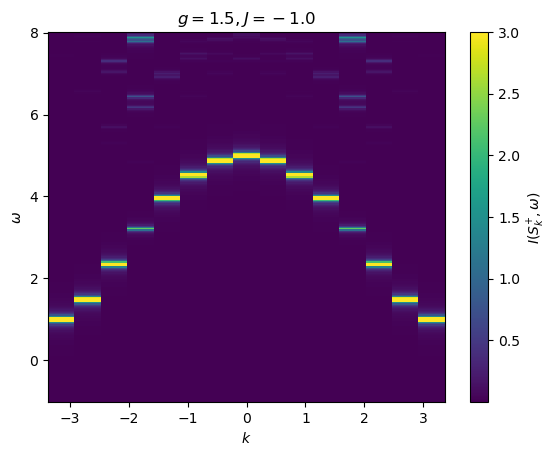

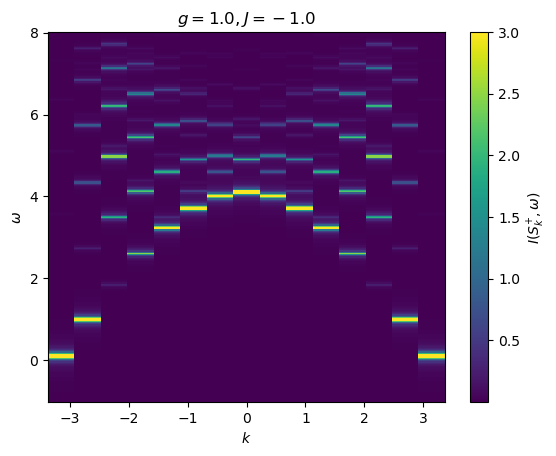

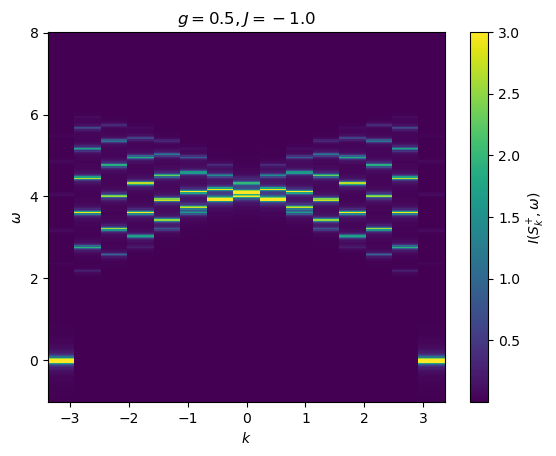

In [19]:
for (g, J) in [(1.5, 1.), (1.0, 1.), (0.5, 1.), (1.5, -1.), (1.0, -1.), (0.5, -1.)]:
    gen_plot_I(g, J)